# Modelling and Computational Engineering Project 2


In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
import scipy.sparse.linalg
import scipy 


%matplotlib inline

In [150]:
class RadialDiffusivityEquationSolver:
    """
    A finite difference solver for the radial diffusivity equation.
    We use the coordinate transformation y = ln(r/rw) to set up and
    solve the pressure equation.

    The solver uses SI units internally, while "practical field units"
    are required as input.

    Except for the number of grid blocks / points to use, all class
    instance attributes are provided with reasonable default values.

    Input arguments:

        name                                symbol      unit
        --------------------------------------------------------------
        Number of grid points                N          dimensionless
        well radius                          rw         ft
        extent of reservoir                  re         ft
        height of reservoir                  h          ft
        permeability                         k          mD
        porosity                             phi        dimensionless
        fluid viscosity                      mu         mPas (cP)
        total compressibility                ct         1 / psi
        constant flow rate at well           Q          bbl / day
        initial reservoir pressure           pi         psi
        constant time step                   dt         days
        maximal simulation time          max_time       days
        -------------------------------------------------------------
    """

    def __init__(self, N, rw=0.328, re = 100000., h=8.0,
                 k=500, phi=0.1, mu=1.0, ct=17.7e-6,
                 Q=1000, pi=2000, dt=0.1, max_time=10):

        # Unit conversion factors (input units --> SI)
        self.ft_to_m_ = 0.3048
        self.psi_to_pa_ = 6894.75729
        self.day_to_sec_ = 24*60*60
        self.bbl_to_m3_ = 0.1589873

        # Grid
        self.N_ = N
        self.rw_ = rw*self.ft_to_m_
        self.re_ = re*self.ft_to_m_
        self.h_ = h*self.ft_to_m_

        # Rock and fluid properties
        self.k_ = k*1e-15 / 1.01325
        self.phi_ = phi
        self.mu_ = mu*1e-3
        self.ct_ = ct / self.psi_to_pa_
        self.eta_ = self.k_/(self.mu_*self.phi_*self.ct_)

        # Initial and boundary conditions
        self.Q_ = Q*self.bbl_to_m3_ / self.day_to_sec_
        self.pi_ = pi*self.psi_to_pa_

        # Time control for simulation
        self.dt_ = dt*self.day_to_sec_
        self.max_time_ = max_time*self.day_to_sec_
        self.current_time_ = 0.
         
        # Part4, Discrete midpoints
        self.yw_ = 0
        self.ye_ = np.log(self.re_/self.rw_)
        self.dy_ = (self.ye_-self.yw_)/self.N_
        self.y0_ = self.yw_ + 0.5*self.dy_
        self.y_mids = np.linspace(self.y0_,self.ye_ - 0.5*self.dy_, self.N_)
        self.r_from_mids = self.rw_*np.exp(self.y_mids)
        
        #Diffusivity beta
        self.beta_ = (self.Q_*self.mu_*self.dy_)/(2*np.pi*self.k_*self.h_)
        
        
    
        
    def line_source_solution(self, t, r):
        return self.pi_ + ((self.Q_*self.mu_)/(4*np.pi*self.k_*self.h_))*sc.expi(-(r**2)/(4*self.eta_*t*self.day_to_sec_)) 
   
    def xi(self,y_i):
        """Function that calculates xi coefficient of y_i input"""
        return self.eta_*np.exp(-2*y_i)*self.dt_/((self.rw_*self.dy_)**2)   
     
    def setup_matrix(self):
        """Function that "sets up" a matrix by storing the coefficients of the linear difference equations
        over the time steps and grid points."""
        
        matrix = np.zeros((self.N_,self.N_))
        
        #First and last row
        matrix[0][0] = 1 + self.xi(self.y_mids[0])
        matrix[0][1] = - self.xi(self.y_mids[0])
        matrix[self.N_-1][self.N_-1] = 1 + self.xi(self.y_mids[self.N_-1])
        matrix[self.N_-1][self.N_-2] = -self.xi(self.y_mids[self.N_-1])
        
        #Mid-rows
        for index in range(self.N_):
            if index == 0 or index == (self.N_ -1):
                pass
            else:
                matrix[index][index-1] = -self.xi(self.y_mids[index])
                matrix[index][index] = 1 + 2*self.xi(self.y_mids[index])
                matrix[index][index+1] = -self.xi(self.y_mids[index])
        
        return(matrix)
   
    
    def setup_sparse_matrix(self):
        """ function that stores diagonal entries and sets up a sparce matrix"""
        
        main_diag =[1 + 2*self.xi(y) for y in self.y_mids]    #list comprehension assigns 1 +2*eta, to all diag-entries
        main_diag[0] = 1 + self.xi(self.y_mids[0])            #correcting first and last row
        main_diag[self.N_-1] = 1+ self.xi(self.y_mids[self.N_-1])
        over_diag = [-self.xi(y) for y in self.y_mids if y != self.y_mids[self.N_-1]]
        under_diag =[-self.xi(y) for y in self.y_mids if y != self.y_mids[0]]
       
        diagonals = [main_diag, over_diag, under_diag]
        sparse_matrix = scipy.sparse.diags(diagonals, [0, 1,-1], format ='csc')
        
        return sparse_matrix
        
    def rhs(self, p_vec):
        """Function that returns the right hand side of the vector equation"""
        p_vec[0] = p_vec[0] - self.xi(y_mids[0])*self.beta_
        return p_vec
        
               
    def top_level(self, t, sparse = 'True', temporal = 'False'):
        """top level function for executing simulation"""
        
        p_vec=self.N_*[self.pi_]        #initial pressure vector
        t_sec = int(t*self.day_to_sec_) #np.arange below does not like non-integer steps. 
        p_at_t =[]
        
        if sparse == 'True':
            matrix = self.setup_sparse_matrix()
            for i in np.arange(0,t_sec, self.dt_):  #n from range (0,t) with stepsize dt: apply sparse solve n times. 
                p_at_t.append(p_vec)
                p_vec = self.rhs(p_vec)
                p_vec = scipy.sparse.linalg.spsolve(matrix,p_vec)
                
        else:
            matrix = self.setup_matrix()
            inverted_matrix = np.linalg.inv(matrix)
            for i in np.arange(0,t_sec, self.dt_):  #n from range (0,t) with stepsize dt: apply invere matrix-mult n times. 
                p_at_t.append(p_vec)
                p_vec = self.rhs(p_vec)
                p_vec = np.matmul(inverted_matrix,p_vec)
                
        if temporal == 'True':
            return p_at_t
        else:
            return(p_vec)
    
    
    def plot_line_source_solution(self, t, r, temporal ='False'):
        
        res_pres= self.line_source_solution(t, r)
        figure = plt.figure()
        plot = figure.add_subplot()
        plot.plot(r,res_pres)
        plot.set_title('Plot of analytical solution')
        plot.set_xscale('log')
        plt.xlabel('Radial distance from line source')
        plt.ylabel('Pressure [Pa]')
     
    def plot_numerical_solution(self,t,sparse ='True', temporal ='False'):
        
        num_out = self.top_level(t, sparse, temporal)    
        figure31 = plt.figure()
        plot31 = figure31.add_subplot()
        plot31.plot(self.r_from_mids, num_out , label = 'Numerical solution')
        plot31.set_xscale('log')
        plot31.set_title('Numerical solution')
        plt.xlabel('Radial distance from line source')
        plt.ylabel('Pressure [Pa], Calculated Numerically')

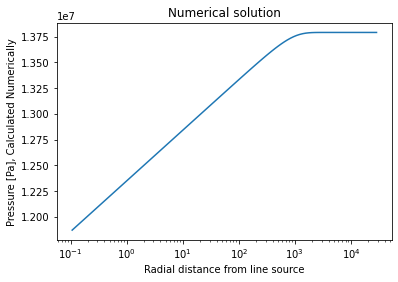

In [151]:


testing = RadialDiffusivityEquationSolver(100)


testing.plot_numerical_solution(2,'True')




##  Exercise 1

### Part 1

In [32]:
df = pd.read_csv('data/perm_data.dat', skiprows=4, sep = '\t')

Task: import file and plot $\Delta P$ vs $Q$

In [33]:
print(df)

   q[ml/s]  DP[atm]
0      0.1    0.396
1      0.2    0.170
2      0.3    0.720
3      0.6    0.369
4      1.0    1.406
5      1.5    2.318
6      2.0    8.000


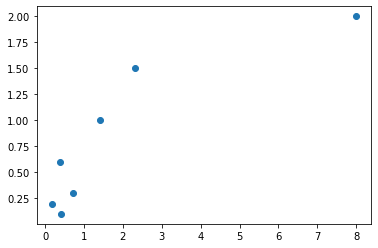

In [34]:
plt.scatter(df['DP[atm]'],df['q[ml/s]'])

### Part 2

Matrix linear regression

In [13]:
from numpy.linalg import solve
def OLSM(x, y):
# returns regression coefficients
# in ordinary least square using solve function
# x: observations
# y: response
    XT = np.array([np.ones(len(x)),x], float)
    YT = y
    Y = np.transpose(y)
    X = np.transpose(XT)
    B = np.dot(XT,X)
    C = np.dot(XT,YT)
    return solve(B,C)

OLSM(df['DP[atm]'],df['q[ml/s]'])


array([0.38382154, 0.22522231])

Text(0, 0.5, 'q [ml/s]')

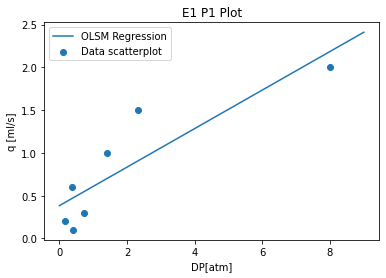

In [14]:
outs = OLSM(df['DP[atm]'],df['q[ml/s]'])
xval = np.arange(0,10)
yval = xval*outs[1] +outs[0] 

fig2 = plt.figure()
ax = fig2.add_subplot()
ax.scatter(df['DP[atm]'],df['q[ml/s]'], label = 'Data scatterplot')
ax.plot(xval,yval, label='OLSM Regression')
ax.legend()
plt.title('E1 P1 Plot')
plt.xlabel('DP[atm]')
plt.ylabel('q [ml/s]')

## Exercise 2

### Part 1


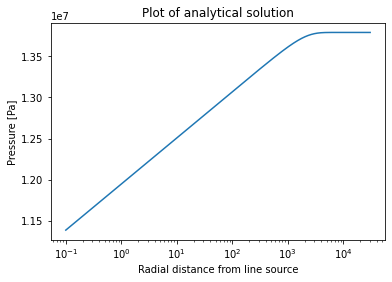

In [35]:
p = RadialDiffusivityEquationSolver(N=500)
r_vec = np.arange(p.rw_,p.re_)

p.plot_line_source_solution(10, r_vec)



### Part 2

Explanation of plot:

### Part 3

Derive the new differential equation with boundary conditions when substituting $y = ln (\frac{r}{r_w})$:

First we recall the differential equation and boundary conditions pre-substitution: 

Differential eq:

\begin{equation}
\frac{\delta p}{\delta t} = \eta \frac{1}{r} \frac{\delta}{\delta r}(r \frac{\delta p}{\delta r})
\end{equation}

Boundary condition at $r = r_w$: 

\begin{equation}
\frac{2 \pi h k r}{\mu} \frac{\delta p}{\delta r} |_{r = r_w} = Q
\end{equation}


Boundary condition at $r = r_e$:

\begin{equation}
\frac{\delta p}{\delta r} |_{r = r_e} = 0
\end{equation}

 
 #### Answer:
 
 First, we apply the chain rule to $\frac{\delta p}{\delta r}$
 \begin{equation}
 \frac{\delta p}{\delta r} = \frac{\delta p}{\delta y} \frac{\delta y}{\delta r}
 \end{equation}

\begin{equation}
\frac{\delta p}{\delta r} =  \frac{1}{r} \frac{\delta p}{\delta y} = \frac{1}{r_w}e^{-y} \frac{\delta p}{\delta y} 
\end{equation}

Note that from the defitnion of $y$, $r = r_w e^y$


Then we insert into the differential: 


\begin{equation}
\frac{\delta p}{\delta t} = \eta \frac{1}{r_w}e^{-y} \frac{\delta}{\delta r}( r_w e^y \frac{1}{r_w}e^{-y} \frac{\delta p}{\delta y} )=
\end{equation}


\begin{equation}
\frac{\delta p}{\delta t} = \eta \frac{1}{r_w}e^{-y} \frac{\delta}{\delta r}(\frac{\delta p}{\delta y} )
\end{equation}

Again, we must use the chain rule:

Let $u =\frac{\delta p}{\delta y}$

\begin{equation}
\frac{\delta u}{\delta r} = \frac{\delta u}{\delta y} \frac{\delta y}{ \delta r} = \frac{1}{r} \frac{\delta u}{\delta y} = \frac{1}{r_w}e^{-y} \frac{{\delta}^2 p}{\delta y^2}
\end{equation}

Which then gives us our expression: 

\begin{equation}
\frac{\delta p}{\delta t} = \eta \frac{1}{{r_w}^2} e^{-2y} \frac{{\delta}^2 p}{\delta y^2}
\end{equation}

We can then turn our attention to the boundary coondition at $r = r_w$:

\begin{equation}
\frac{2 \pi h k r}{\mu} \frac{\delta p}{\delta r} |_{r = r_w} = \frac{2 \pi h k  r_w e^y}{\mu} \frac{1}{r_w} e^{-y} \frac{\delta p}{\delta y} |_{y = y_w} = \frac{2 \pi h k}{\mu} \frac{\delta p}{\delta y} |_{y = y_w} = Q
\end{equation}

Which can be rewritten as:

\begin{equation}
\frac{\delta p}{\delta y} |_{y = y_w} = \frac{Q \mu }{2 \pi h k}
\end{equation}

Finally, the boundary condition at $r = r_w$

\begin{equation}
\frac{\delta p}{\delta r} |_{r = r_e} = \frac{1}{r_w}e^{-y} \frac{\delta p}{\delta y} |_{y = y_e} =0 
\end{equation}



Which implies:
\begin{equation}
\frac{\delta p}{\delta y} |_{y = y_e} =0 
\end{equation}

### Part 4

In [36]:
attempt = RadialDiffusivityEquationSolver(N=50)

In [37]:
N =50
y_w = 0
y_e = np.log(attempt.re_/attempt.rw_)
y = np.linspace(y_w, y_e, num =N)
dy = np.linspace(y_w,y_e, num =N, retstep = True)[1]
y_mids = np.linspace(y_w+0.5*dy, y_e, N)
#print(y_mids, y)
r_from_mids = attempt.rw_*np.exp(y_mids)
#print(r_from_mids)




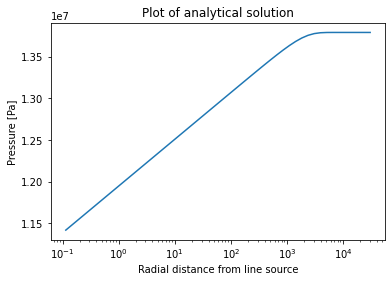

In [38]:
attempt.plot_line_source_solution(10, r_from_mids)


We get the same plot as we've previously seen so i guess it's correct?

### Part 5


Suppose that we solve the equation using the discrete solution: 

\begin{equation}
\frac{p_i^{n+1} - p_i^{n}}{\Delta t} = \eta \frac{e^{-2 y_i}}{r_w^2} \frac{p_{i+1}^{n+1} + p_{i-1}^{n+1}-2 p_{i}^{n+1}}{\Delta y^2}
\end{equation}

With $N = 4$ grid points. 

#### Answer:

$i = 0$
\begin{equation}
\frac{p_0^{n+1} - p_0^{n}}{\Delta t} = \eta \frac{e^{-2 y_0}}{r_w^2} \frac{p_{1}^{n+1} + p_{-1}^{n+1}-2 p_{0}^{n+1}}{\Delta y^2}
\end{equation}


$i = 1$
\begin{equation}
\frac{p_1^{n+1} - p_1^{n}}{\Delta t} = \eta \frac{e^{-2 y_1}}{r_w^2} \frac{p_{2}^{n+1} + p_{0}^{n+1}-2 p_{1}^{n+1}}{\Delta y^2}
\end{equation}

$i = 2$
\begin{equation}
\frac{p_2^{n+1} - p_2^{n}}{\Delta t} = \eta \frac{e^{-2 y_2}}{r_w^2} \frac{p_{3}^{n+1} + p_{1}^{n+1}-2 p_{2}^{n+1}}{\Delta y^2}
\end{equation}

$i = 3$
\begin{equation}
\frac{p_3^{n+1} - p_3^{n}}{\Delta t} = \eta \frac{e^{-2 y_3}}{r_w^2} \frac{p_{4}^{n+1} + p_{2}^{n+1}-2 p_{3}^{n+1}}{\Delta y^2}
\end{equation}



### Part 6

To get rid of the out of range values of $p_{-1}$ and $p_4$, we employ the (second order) finite difference approximation at the boundaries:



First order discrete difference equation: 
\begin{equation}
\frac{\partial p}{\partial t} =
\frac{p(y_i, t+\Delta t)-p(y_i, t)}{\Delta t} + \mathcal{O}(\Delta t)
\equiv \frac{p_{i}^{n+1}-p_{i}^n}{\Delta t} + \mathcal{O}(\Delta t).
\end{equation}

and also:
\begin{equation}
\frac{\partial p}{\partial y} =
\frac{p_{i+1}^{n+1}-p_{i}^{n+1}}{\Delta y} + \mathcal{O}(\Delta y).
\end{equation}

(where we utilize ($p_i^{n+1}$, the solution at $(t+ \Delta t)$ as the implicit scheme)






#### Boundary condition at $y = y_e$:
$$
\frac{\delta p}{\delta y} |_{y = y_e} =0 
$$

Which then gives: 
\begin{equation}
\frac{p_4^{n+1}-p_{3}^{n+1}}{\Delta y} + \mathcal{O}(\Delta y) = 0
\end{equation}



Assuming that $\mathcal{O}(\Delta y)$ approaches zero, we get the condition: $p_4^{n+1}=p_{3}^{n+1}$

#### Boundary condition at $y = y_w$:


\begin{equation}
\frac{\delta p}{\delta y} |_{y = y_w} = \frac{Q \mu }{2 \pi h k}
\end{equation}

Consider the differential at i = -1. 

\begin{equation}
\frac{p_0^{n+1} - p_{-1}^{n+1}}{\Delta y} = \frac{Q \mu }{2 \pi h k}
\end{equation} 

Which gives us:
\begin{equation}
p_{-1}^{n+1} = p_0^{n+1} - \frac{Q \mu \Delta y}{2 \pi h k } = p_0^{n+1} - \beta 
\end{equation}

#### Inserting:

Note, we define:
$$
\xi_i \equiv \frac{\eta e^{-2 y_i} \Delta{t}}{r_w^2 \Delta{y}^2}\,,
$$

Inserting our expression at $i = 0$:

\begin{equation}
p_0^{n+1} - p_0^{n} = \xi_0 (p_{1}^{n+1} + p_{-1}^{n+1}-2 p_{0}^{n+1})
\end{equation}




\begin{equation}
p_0^{n+1} - p_0^{n} = \xi_0 (p_{1}^{n+1} +p_0^{n+1} - \beta  + p_{0}^{n+1} -2 p_{0}^{n+1})
\end{equation}



\begin{equation}
p_0^{n+1}(1+\xi_0)  - \xi_0 p_1^{n+1} = p_0^n - \xi_0 \beta 
\end{equation} 


$i = 1$


\begin{equation}
p_1^{n+1} - p_1^{n} = \xi_1 (p_{2}^{n+1} + p_{0}^{n+1}-2 p_{1}^{n+1})
\end{equation}


$\rightarrow$
\begin{equation}
 -\xi_1 p_0^{n+1} +(1+2\xi_1)p_1^{n+1} - \xi_1 p_2^{n+1}= p_1^n 
\end{equation}


$i = 2$


\begin{equation}
p_2^{n+1} - p_2^{n} = \xi_2 (p_{3}^{n+1} + p_{1}^{n+1}-2 p_{2}^{n+1})
\end{equation}


$\rightarrow$
\begin{equation}
 -\xi_2 p_2^{n+1} +(1+2\xi_2)p_2^{n+1} - \xi_2 p_3^{n+1}= p_2^n 
\end{equation}


$i = 3$


\begin{equation}
p_3^{n+1} - p_3^{n} = \xi_3 (p_{4}^{n+1} + p_{2}^{n+1}-2 p_{3}^{n+1})
\end{equation}

$\rightarrow$
\begin{equation}
p_3^{n+1} - p_3^{n} = \xi_3 (p_{3}^{n+1} + p_{2}^{n+1}-2 p_{3}^{n+1})
\end{equation}

$\rightarrow$
\begin{equation}
-\xi_3 p_2^{n+1} +(1+\xi_3) p_3^{n+1} = p_3^n
\end{equation}

These expressions can then be converted to matrix form: 
    
\begin{equation}
\begin{pmatrix}
1+\xi_0&-\xi_0&0&0\\ 
-\xi_1&1+2\xi_1&-\xi_1&0\\ 
0&-\xi_2&1+2\xi_2&-\xi_2\\ 
0&0&-\xi_3&1+\xi_3\\ 
\end{pmatrix}
\begin{pmatrix}
p_0^{n+1}\\ 
p_1^{n+1}\\ 
p_2^{n+1}\\ 
p_3^{n+1}\\ 
\end{pmatrix}
=
\begin{pmatrix} 
p_0^{n}-\xi_0\beta\\ 
p_1^{n}\\ 
p_2^{n}\\ 
p_3^{n}\\ 
\end{pmatrix}
\end{equation}

## Exercise 3

### Part 2

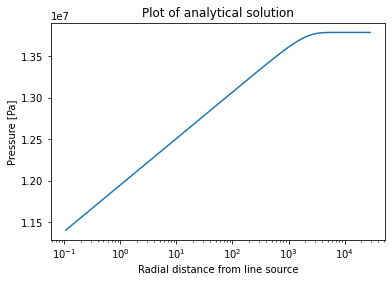

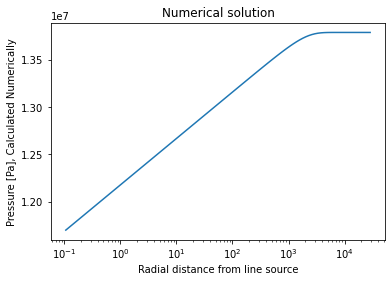

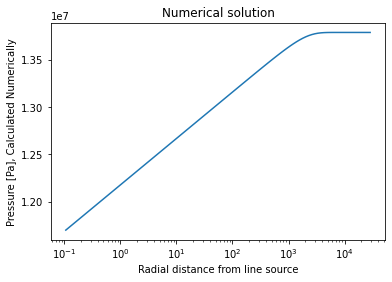

In [152]:
instance = RadialDiffusivityEquationSolver(100)

t= 10
r = instance.r_from_mids

instance.plot_line_source_solution(t,r)
instance.plot_numerical_solution(t, 'True')
instance.plot_numerical_solution(t, 'False')


We can see from the plots that both of the numerical solution match the analytical solution.

### Part 3


In [153]:
Part_3_instance =RadialDiffusivityEquationSolver(1000)

%timeit Part_3_instance.top_level(10, sparse ='True')
%timeit Part_3_instance.top_level(10, sparse ='False')


32.5 ms ± 88.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
53.3 ms ± 1.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


As we can see, the non-sparse approach is somewhat slower

## Exercise 4

### Part 1

In [144]:
df2 = pd.read_csv('data/well_test.dat', skiprows=3, sep = '\t')
print(df2)

    time  well_pressure
0      0           1900
1     10           1849
2     20           1784
3     40           1726
4     80           1661
5    150           1595
6    300           1508
7    500           1421
8    800           1320
9   1200           1211
10  1500           1131
11  2000            986
12  2500            856
13  3000            718


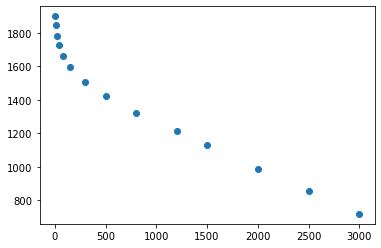

In [145]:
plt.scatter(df2['time'], df2['well_pressure'])

We can see a distinct large initial decrease of preassure which seamingly develops into a more linear decrease. 

### Part 2

\begin{equation}
\frac{\delta p}{\delta y} |_{y = y_w} = \frac{Q \mu }{2 \pi h k}
\end{equation}

first order discrete approximation with ($h =\Delta y /2$): 

\begin{equation}
\frac{p^{n+1}_0 -p^{n+1}_w}{\Delta y /2} = \frac{Q \mu }{2 \pi h k}
\end{equation}

\begin{equation}
 p^{n+1}_w = p^{n+1}_0 -\frac{Q \mu \Delta y }{ 4\pi h k}
\end{equation}